# Project Path Planning
In this notebook we look at the first project on path-planning which covers following point
* How the simulator works
* Transform from Cartesian x,y coordinates to Frenet s,d coordinates
* Path-planning using Finite-State-Machine and cost function

## How the simulator works
One can find the source code for the simulator from [here](https://github.com/udacity/self-driving-car-sim). To build the simulator for this project:
* you need to switch to branch `term3_collection` (note that you need to install git-lfs and run `git lfs fetch; git lfs pull` to pull the asset files)
* you select only PathPlanning scene to build (otherwise it won't work since the MenuScene for the PathPlanning is not provided).

### Path planner
The car-driving simulator for this project is implemented in `perfect_controller.cs` which works as following
* it receives from the planner the list of next_x, next_y
* at each step, it computes the next step from next_x, next_y and drive to this next point
* each step from one point to the next one, it considers 0.02 second

Note that, after consumed some `(next_x, next_y)`, it sends the following data to the planner:
* x, y: Cartesian coordinates of current position
* s, d: Frenet coordinates
* yaw, speed: car's direction and speed
* previous_path_x, previous_path_y: previous path data given to the Planner
* end_path_s, end_path_d: previous path's end in Frenet (s,d)
* sensor_fusion: a list of all other cars on the same side of the road

One point to be careful, from the time the planner received the simulator data to the time the receiver received the next `(next_x, next_y)`, the simulator might consumed some point of previous planned paths (due to latency).

In this part we try some simple experiments to verify our understanding of the simulator. The code is done in `experiments.cpp`.

### Experiments - Naively following center lane
The code to make the car drives in the center lane is implemented in the function `getTrajectoryKeepLaneNaive` which does
* plan next points in Frenet with `d = 2 + 4* lane` and `s` advanced each time by a constant `s_inc`
* the next points are converted back to Cartesian then sent to the simulator

We notice the following
* the car's speed is flipping from 33MPH to near 0MPH very often
* the car breaks speed limit few times (when the road is curvy)
* the car's trajectory is not smooth

Let's investigate what causes this behavior. We log out the current state and planned steps in a csv file

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [142]:
# load data
drive_df = pd.read_csv('drive-logs/experiment1-drive.csv', delimiter=';', 
                 names=['step', 'tag', 'vals'], 
                 converters={'vals' : lambda x: eval(x)})

sim_df = pd.read_csv('drive-logs/experiment1-sim.csv', names=['step', 'x', 'y'], delimiter=' ')

# print first step
drive_df[drive_df.step==1]

,step,tag,vals
0,1,x,909.48
1,1,y,1128.67
2,1,s,124.834
3,1,d,6.165
4,1,yaw,0
5,1,speed,0
6,1,end_path_s,0
7,1,end_path_d,0
8,1,previous_path_x,[]
9,1,previous_path_y,[]


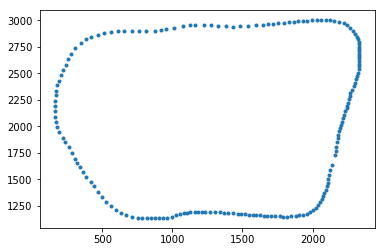

In [141]:
high_way = pd.read_csv('../data/highway_map.csv', delimiter=' ',
                       names=['x','y','s','dx','dy'])

from utils import Highway

hwm = Highway('../data/highway_map.csv')
_ = plt.plot(high_way.x, high_way.y, '.')

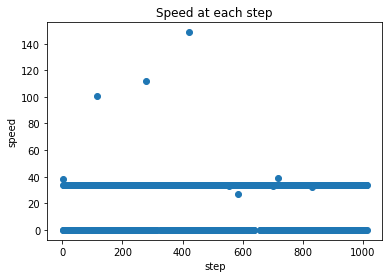

In [127]:
# get speed view
speed=drive_df[drive_df.tag=='speed']
plt.scatter(speed.step, speed.vals)
plt.title('Speed at each step')
plt.xlabel('step')
_=plt.ylabel('speed')

#### Why speed is flipping from 33MPH to 0MPH very often
We add some logging in the simulator and we found that at time step `t`
* when we are computing the next_x and next_y, the car might consume some more points (from previous planned path)
* when the simulator received the next_x, next_y, the car might be at some point very close to one point in this planned path (but not exact) due to this the speed is close to 0

Here is the illustration at time step `t=1`

step 1 [ 909.7784  910.0784] [ 1128.838  1128.84 ]
step 2 [ 910.0783] [ 1128.84]


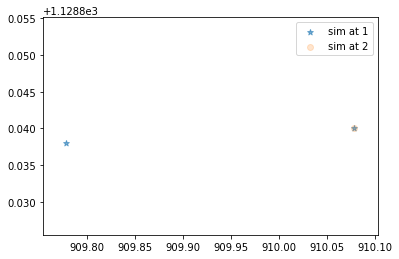

In [128]:
markers = ['o','*']
for t in range(1, 3):
    sim_x = sim_df[sim_df.step==t].x.values
    sim_y = sim_df[sim_df.step==t].y.values
    print('step {}'.format(t), sim_x, sim_y)
    plt.scatter(sim_x, sim_y, 
                marker=markers[t%len(markers)], 
                label='sim at {}'.format(t), alpha=1-0.4*t)
    
_=plt.legend()

One can see that at the step 2, we start at a point very close to the point that we already parsed. This is the main reason that causes the speed flipping between 0MPH and 33MPH.

#### Why it breaks speed limit
Note that we works on Frenet coordinate with constant speed in `s` direction. However, when translate into Cartesian, the speed can be very different especially when the road is curvy for example at time step `t=116`

In [129]:
print(np.where(speed.vals>50))

(array([116, 277, 419]),)


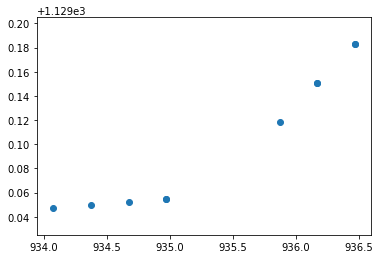

In [130]:
x_steps = np.array([])
y_steps = np.array([])

x_nearestwp = []
y_nearestwp = []
for t in range(110,120):
    x_steps=np.append(x_steps, sim_df[sim_df.step==t].x.values)
    y_steps=np.append(y_steps, sim_df[sim_df.step==t].y.values)
    
    
plt.scatter(x_steps, y_steps)

We can see at step 115 to 116, the two points is quite far apart, let's look at the nearest waypoints

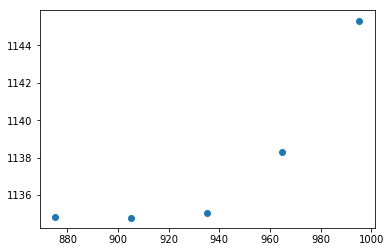

In [131]:
inearest = []
for x,y in zip(x_steps, y_steps):
    inearest.append(hwm.closestWaypoint(x, y))
  
_=plt.scatter(high_way.x[np.min(inearest)-2:np.max(inearest)+3], 
              high_way.y[np.min(inearest)-2:np.max(inearest)+3])

One can find the the road is quite curvy which can cause that by changing in Frenet by 33MPH, it can be much bigger in Cartesian. This is the reason that causes our car breaking speed-limit.

#### Why the trajectory is not smooth
Note that we **regenerate** a trajectory in Frenet coordinate and convert back to Cartesian. This conversion between Frenet and Cartesian is not very precise since

* the highway maps is quite sparse (each consecutive points have a distance of `30m`)
* the convert from Cartesian to Frenet then revert back to Cartesian can have big inconsistence.

Here is an example

Max x-diff 30.404008997964866
Max y-diff 30.404008997964866


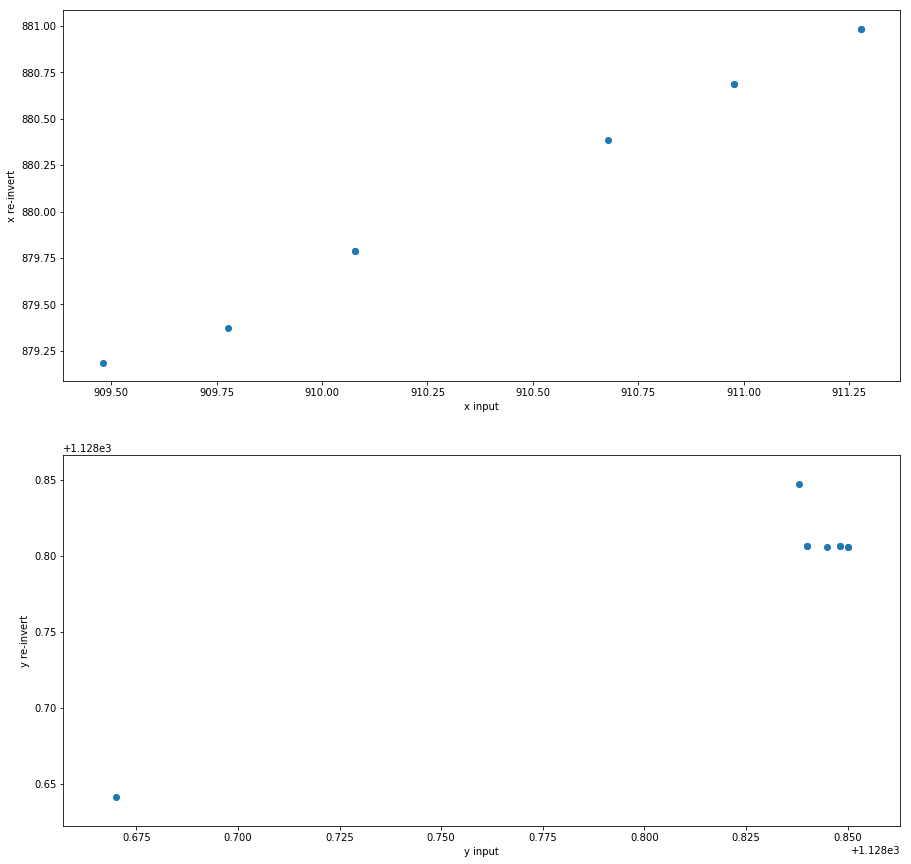

In [132]:
x_y_yaw = []
s_d = []
x_y_reinvert = []
for t in range(1,10):
    idx = 12 * (t - 1)

    x = drive_df.vals[idx]
    y = drive_df.vals[idx + 1]
    yaw = drive_df.vals[idx + 4]
    x_y_yaw.append([x,y,yaw])
    s,d = hwm.getFrenet(x, y, yaw)
    x,y = hwm.getXY(s, d)
    x_y_reinvert.append([x, y])
    
x_y_yaw = np.array(x_y_yaw)
x_y_reinvert = np.array(x_y_reinvert)
f, axs = plt.subplots(2,1,figsize=(15,15))
axs[0].scatter(x_y_yaw[:, 0], x_y_reinvert[:, 0])
axs[0].set_xlabel('x input')
axs[0].set_ylabel('x re-invert')
axs[1].scatter(x_y_yaw[:, 1], x_y_reinvert[:, 1])
axs[1].set_xlabel('y input')
axs[1].set_ylabel('y re-invert')

print('Max x-diff {}'.format(np.max(np.abs(x_y_yaw[:, 0] - x_y_reinvert[:, 0]))))
print('Max y-diff {}'.format(np.max(np.abs(x_y_yaw[:, 0] - x_y_reinvert[:, 0]))))

Note that the highway map has each consecutive points is 30m apart so when we convert back and forth between Cartesian and Frenet, it's quite easy to introduce these error.

### Solution
We need to find solution for the above issue
* latency: to tackle this, we need to use previous_path_x, previous_path_y and we append the next points into this list. This will ensure our trajectory is continuous and speed won't go to 0
* speed-limit: we need to ensure the car's speed in Cartesian (more detail in the following)
* trajectory not smooth: we should keep previous_path_x, previous_path_y and we append the next planner points into the list. Note that to handle the inconsistence due to conversion between Frenet and Cartesian one can Spline to interpolate the highway points to make it 1m apart (instead of 30m apart).

#### Using the previous path to tackle latency
The implementation is done in `getTrajectoryKeepLaneAppending`

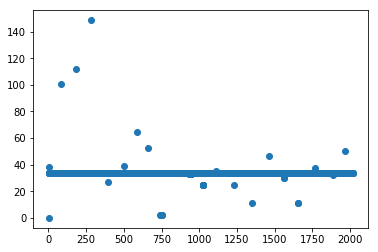

In [59]:
drive2_df = pd.read_csv('drive-logs/experiment2-drive.csv', delimiter=';', 
                 names=['step', 'tag', 'vals'], 
                 converters={'vals' : lambda x: eval(x)})
sim2_df = pd.read_csv('drive-logs/experiment2-sim.csv', names=['step', 'x', 'y'], delimiter=' ')
speed2 = drive2_df[drive2_df.tag=='speed']
plt.scatter(speed2.step, speed2.vals)

Let's check why speed still comes close to 0 at few time steps

In [111]:
print(speed2[speed2.vals<20].step)

5           1
10393     743
10407     744
10421     745
10435     746
10449     747
10463     748
10477     749
10491     750
10505     751
18905    1351
23189    1657
23203    1658
Name: step, dtype: int64


Look at above result, one can see that the simulator consumes 1-2 points each step.

In [45]:
def build_idx_map(df):
    tags = df[df.step==1].tag.values
    
    retval = {}
    for key in tags:
        retval[key] = df[(df.step==1)&(df.tag==key)].index.values[0]

    return retval

def get_next_sdxy(log_drive, idx_map, step):
    log_at_step = log_drive[log_drive.step==step]
    next_s_vals = log_at_step.iloc[idx_map['next_s_vals']].vals
    next_d_vals = log_at_step.iloc[idx_map['next_d_vals']].vals
    next_x_vals = log_at_step.iloc[idx_map['next_x_vals']].vals
    next_y_vals = log_at_step.iloc[idx_map['next_y_vals']].vals
    return next_s_vals, next_d_vals, next_x_vals, next_y_vals

def scatter_plot(ax, title, xs, ys, labels, sizes, alphas):
    ax.set_title(title)
    
    for i in range(len(xs)):
        ax.scatter(xs[i], ys[i], label=labels[i], s=sizes[i], alpha=alphas[i])
    ax.legend()

In [ ]:
def visualize(log_drive, log_sim, step, nb_point=10):
    idx_map = build_idx_map(log_drive)
    next_s_vals, next_d_vals, next_x_vals, next_y_vals = get_next_sdxy(log_drive, idx_map, step)
    fig, axes = plt.subplots(2, 2, figsize=(15,10))

    # number of new s,d might be less than nb_point
    nb_sd_to_view = min(nb_point, len(next_s_vals))
    
    axes[0, 0].scatter(next_s_vals[:nb_sd_to_view],  next_d_vals[:nb_sd_to_view], 
                       s=10, label='first {} planned (s, d)'.format(nb_sd_to_view))
    axes[0, 0].set_title('First {} planned points in Frenet'.format(nb_sd_to_view))
    
    axes[0, 1].scatter(next_s_vals[-nb_sd_to_view:], next_d_vals[-nb_sd_to_view:], 
                       s=10, label='last {} planned (s,d)'.format(nb_sd_to_view))
    axes[0, 1].set_title('Last {} planned points in Frenet'.format(nb_sd_to_view))
    axes[0, 0].get_shared_x_axes().join(axes[0, 0], axes[0, 1])    
    
    axes[1, 0].scatter(next_x_vals[:nb_point],  next_y_vals[:nb_point], s=10, 
                       label='first {} planned (x, y)'.format(nb_point))
    axes[1, 0].set_title('First {} planned points in Catersian'.format(nb_point))
    
    axes[1, 1].scatter(next_x_vals[-nb_point:], next_y_vals[-nb_point:], s=10,
                       label='last {} planned (x, y)'.format(nb_point))
    axes[1, 1].set_title('Last {} planned points in Catersian'.format(nb_point))
    #axes[0, 1].get_shared_x_axes().join(axes[0, 1], axes[1, 1]) 
    
    # draw previous steps
    if step > 1:
        s_vals, d_vals, x_vals, y_vals = get_next_sdxy(log_drive, idx_map, step - 1)
        nb_sd_to_view = min(nb_point, len(s_vals))
        axes[0, 1].scatter(s_vals[-nb_sd_to_view:], d_vals[-nb_sd_to_view:],
                           s=40,alpha=0.2, label='last {} planned (s, d) in previous step'.format(nb_sd_to_view))
        
        axes[1, 1].scatter(x_vals[-nb_point:], y_vals[-nb_point:],
                           s=40,alpha=0.2, label='last {} planned (x, y) in previous step'.format(nb_point))
        
    for ax in axes.flat:
        ax.legend()

Let's look at step 743 where speed is close to 0

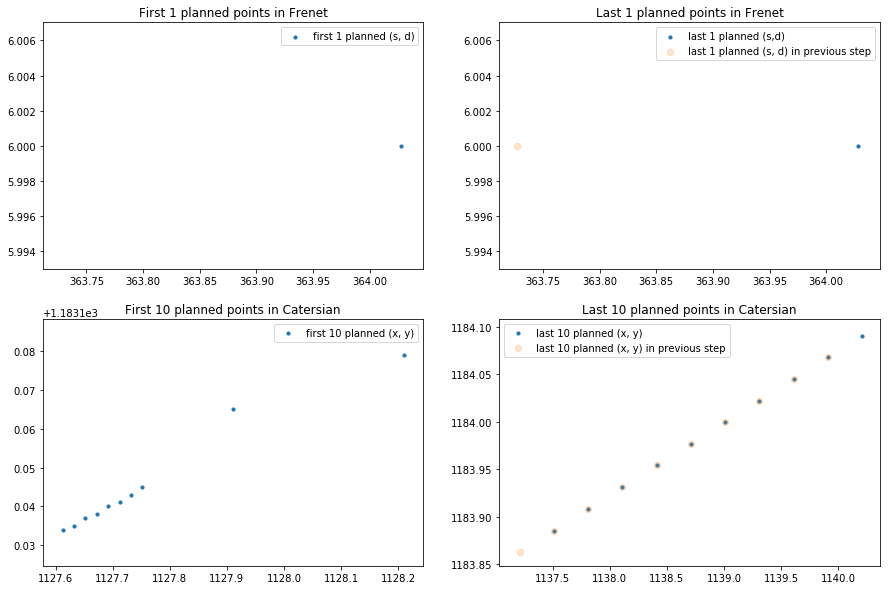

In [116]:
visualize(drive2_df, sim2_df, 743)

We can see that the first few points are very close together. Note that these points are planned from 50 steps before, so we can look at step 693

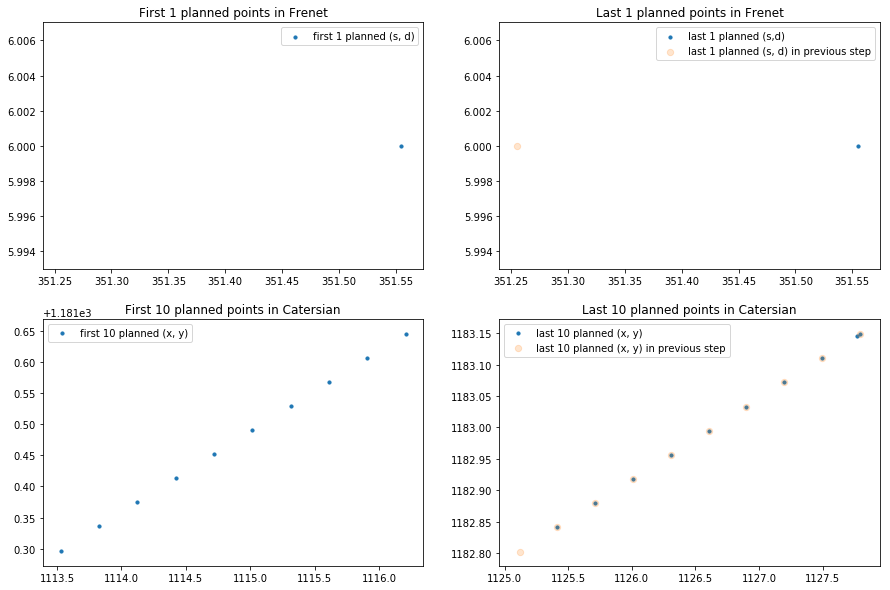

In [108]:
visualize(drive2_df, sim2_df, 693)

We find that the newly generated point is very close to the previous point

In [137]:
def log_at_step(log_drive, step):
    idx_map = build_idx_map(log_drive)
    
    log_at_step = log_drive[log_drive.step==step]
    print('At step {} (s, d) = ({}, {}) => (x, y) = ({}, {})'.format(
        step,
        log_at_step.iloc[idx_map['next_s_vals']].vals[-1],
        log_at_step.iloc[idx_map['next_d_vals']].vals[-1],
        log_at_step.iloc[idx_map['next_x_vals']].vals[-1],
        log_at_step.iloc[idx_map['next_y_vals']].vals[-1]
    ))
   
    
log_at_step(drive2_df, 692)
log_at_step(drive2_df, 693)

At step 692 (s, d) = (351.255, 6.0) => (x, y) = (1127.792, 1183.149)
At step 693 (s, d) = (351.555, 6.0) => (x, y) = (1127.772, 1183.146)


This is due to the conversion from Frenet to Cartesian where the prev index of s is changed between step 692 and 693

In [140]:
print('at step 692, prevWp = ', hwm.getPrevS(351.255))
print('at step 693, prevWp = ', hwm.getPrevS(351.555))

at step 692, prevWp =  11
at step 693, prevWp =  12


To summarise, the conversion between Frenet and Cartesian causes the following issues
* const speed in Frenet can vary a lot in Cartesian
* a smooth trajectory in Frenet can be un-smooth in Cartesian

To solve these issues we need to
* control speed in Cartesian
* generate trajectory in Cartesian

Also as suggested in the lecture, we will do the planning in the car's local coordinate using Spline